In [5]:
pip install git+https://github.com/IAOCEA/xarray-healpy.git

  Cloning https://github.com/IAOCEA/xarray-healpy.git to /tmp/pip-req-build-0zf6tv16
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/xarray-healpy.git /tmp/pip-req-build-0zf6tv16
  Resolved https://github.com/IAOCEA/xarray-healpy.git to commit 9e457091957aa0d7833280558e60e1addc500ec7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached cdshealpix-0.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
Using cached cdshealpix-0.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Created wheel f

In [6]:
import xarray as xr
import fsspec
from xarray_healpy import HealpyGridInfo, HealpyRegridder
import numpy as np

In [7]:
url = "https://data-fair2adapt.ifremer.fr/riomar/GAMAR/GAMAR_1h_inst_Y2004M01.nc"

In [8]:
fs = fsspec.filesystem("http")
ds = xr.open_dataset(fs.open(url), engine='h5netcdf')
ds

<xarray.Dataset> Size: 292GB
Dimensions:              (s_rho: 40, s_w: 41, y_rho: 838, x_rho: 727, y_u: 838,
                          x_u: 726, y_v: 837, x_v: 727, time_counter: 744,
                          axis_nbounds: 2)
Coordinates:
  * s_rho                (s_rho) float32 160B -0.9875 -0.9625 ... -0.0125
  * s_w                  (s_w) float32 164B -1.0 -0.975 -0.95 ... -0.025 0.0
    nav_lat_rho          (y_rho, x_rho) float32 2MB ...
    nav_lon_rho          (y_rho, x_rho) float32 2MB ...
    nav_lat_u            (y_u, x_u) float32 2MB ...
    nav_lon_u            (y_u, x_u) float32 2MB ...
    nav_lat_v            (y_v, x_v) float32 2MB ...
    nav_lon_v            (y_v, x_v) float32 2MB ...
    time_instant         (time_counter) datetime64[ns] 6kB ...
  * time_counter         (time_counter) datetime64[ns] 6kB 2004-01-01T00:58:3...
Dimensions without coordinates: y_rho, x_rho, y_u, x_u, y_v, x_v, axis_nbounds
Data variables: (12/16)
    time_instant_bounds  (time_counter, ax

In [4]:
ds["nav_lat_rho"] = ds["nav_lat_rho"].assign_attrs(standard_nanme="latitude")
ds["nav_lon_rho"] = ds["nav_lon_rho"].assign_attrs(standard_nanme="longitude")

In [5]:
ds = ds.rename_vars({"nav_lat_rho": "latitude", "nav_lon_rho": "longitude"})

In [6]:
ds.thin(20).to_netcdf("GAMAR_1h_inst_Y2004M01_thin=20.nc")

In [13]:
ds.thin(20).to_zarr("GAMAR_1h_inst_Y2004M01_thin=20.zarr")

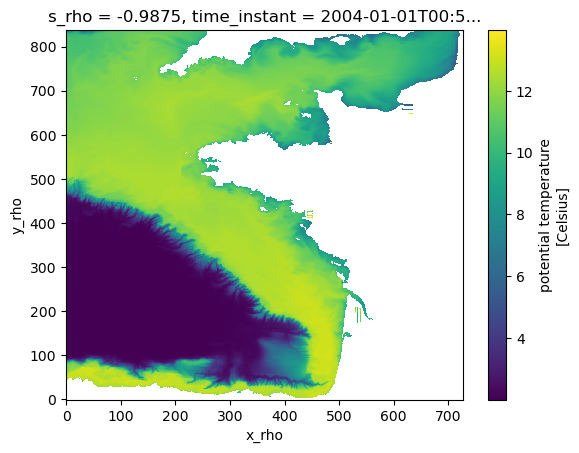

In [9]:
ds.isel(time_counter=0, s_rho=0)["temp"].plot()

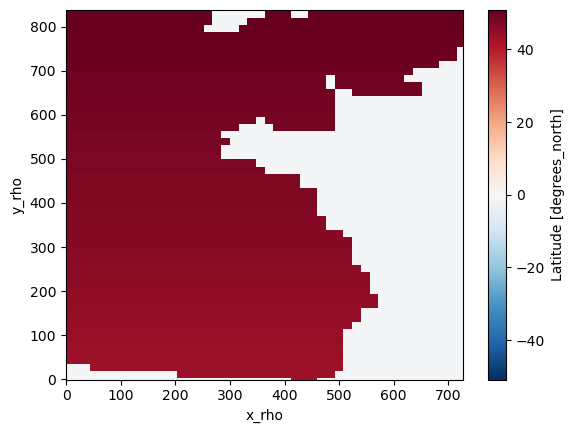

In [19]:
ds[["temp"]].nav_lat_rho.plot()

In [43]:
ds.temp

<xarray.DataArray 'temp' (time_counter: 38, s_rho: 2, y_rho: 42, x_rho: 37)> Size: 472kB
dask.array<open_dataset-temp, shape=(38, 2, 42, 37), dtype=float32, chunksize=(19, 2, 42, 37), chunktype=numpy.ndarray>
Coordinates:
    nav_lat_rho   (y_rho, x_rho) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lon_rho   (y_rho, x_rho) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
  * s_rho         (s_rho) float32 8B -0.9875 -0.4875
  * time_counter  (time_counter) datetime64[ns] 304B 2004-01-01T00:58:30 ... ...
    time_instant  (time_counter) datetime64[ns] 304B dask.array<chunksize=(38,), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho
Attributes:
    cell_methods:        time: point
    interval_operation:  1 h
    interval_write:      1 h
    long_name:           potential temperature
    online_operation:    instant
    units:               Celsius

In [8]:
ds.temp.encoding

{'chunks': (19, 2, 42, 37),
 'preferred_chunks': {'time_counter': 19,
  's_rho': 2,
  'y_rho': 42,
  'x_rho': 37},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'missing_value': 1.0000000200408773e+20,
 '_FillValue': 1e+20,
 'dtype': dtype('float32'),
 'coordinates': 'time_instant nav_lat_rho nav_lon_rho'}

In [63]:
nside = 4096
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180

    return ds.assign_coords(longitude=centered)

In [65]:
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180

    return ds.assign_coords(longitude=centered)

## Open and work with the small zarr

In [9]:
ds = xr.open_zarr("GAMAR_1h_inst_Y2004M01_thin=20.zarr")

In [10]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:              (s_rho: 2, s_w: 3, y_rho: 42, x_rho: 37, y_u: 42,
                          x_u: 37, y_v: 42, x_v: 37, time_counter: 38,
                          axis_nbounds: 1)
Coordinates:
    nav_lat_rho          (y_rho, x_rho) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lat_u            (y_u, x_u) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lat_v            (y_v, x_v) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lon_rho          (y_rho, x_rho) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lon_u            (y_u, x_u) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lon_v            (y_v, x_v) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
  * s_rho                (s_rho) float32 8B -0.9875 -0.4875
  * s_w                  (s_w) float32 12B -1.0 -0.5 0.0
  * time_counter         (time_counter) datetime64[ns] 304B 2004-01-01T00:58:...
    time_instant         (time_counter) datetime64[ns] 304B dask.array<chunksize=(38,), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho, y_u, x_u, y_v, x_v, axis_nbounds
Data variables: (12/16)
    Cs_r                 (s_rho) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    Cs_w                 (s_w) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    Tcline               float32 4B ...
    Vtransform           float32 4B ...
    hc                   float32 4B ...
    salt                 (time_counter, s_rho, y_rho, x_rho) float32 472kB dask.array<chunksize=(19, 2, 42, 37), meta=np.ndarray>
    ...                   ...
    theta_s              float32 4B ...
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 304B dask.array<chunksize=(38, 1), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 304B dask.array<chunksize=(38, 1), meta=np.ndarray>
    u                    (time_counter, s_rho, y_u, x_u) float32 472kB dask.array<chunksize=(19, 2, 42, 37), meta=np.ndarray>
    v                    (time_counter, s_rho, y_v, x_v) float32 472kB dask.array<chunksize=(19, 2, 42, 37), meta=np.ndarray>
    zeta                 (time_counter, y_rho, x_rho) float32 236kB dask.array<chunksize=(38, 42, 37), meta=np.ndarray>
Attributes: (12/45)
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...
    Conventions:    CF-1.6
    Cs_r:           have a look at variable Cs_r in this file
    Cs_w:           have a look at variable Cs_w in this file
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    Tcline:         15.0
    ...             ...
    title:          GAMAR_GLORYS
    tnu4_expl:      biharmonic mixing coefficient for tracers
    units:          meter4 second-1
    uuid:           06f6b784-fcc0-4422-aceb-17da2a5aa9fa
    v_sponge:       0.0
    x_sponge:       0.0

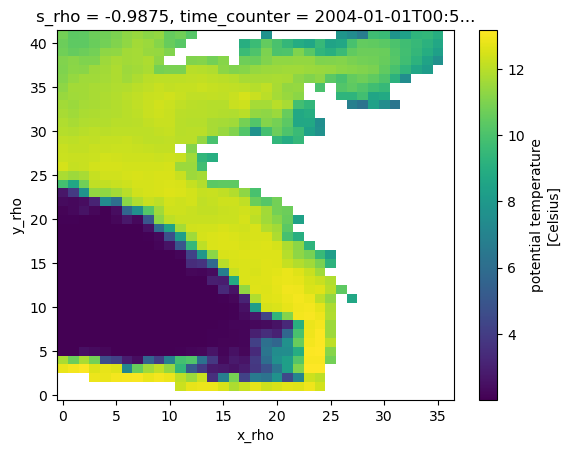

In [11]:
ds.isel(time_counter=0, s_rho=0)["temp"].plot()

In [12]:
ds = ds.assign(ocean_mask = lambda ds: ds.temp.isel(time_counter=0, s_rho=0).notnull())

In [13]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:              (s_rho: 2, s_w: 3, y_rho: 42, x_rho: 37, y_u: 42,
                          x_u: 37, y_v: 42, x_v: 37, time_counter: 38,
                          axis_nbounds: 1)
Coordinates:
    nav_lat_rho          (y_rho, x_rho) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lat_u            (y_u, x_u) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lat_v            (y_v, x_v) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lon_rho          (y_rho, x_rho) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lon_u            (y_u, x_u) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
    nav_lon_v            (y_v, x_v) float32 6kB dask.array<chunksize=(42, 37), meta=np.ndarray>
  * s_rho                (s_rho) float32 8B -0.9875 -0.4875
  * s_w                  (s_w) float32 12B -1.0 -0.5 0.0
  * time_counter         (time_counter) datetime64[ns] 304B 2004-01-01T00:58:...
    time_instant         (time_counter) datetime64[ns] 304B dask.array<chunksize=(38,), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho, y_u, x_u, y_v, x_v, axis_nbounds
Data variables: (12/17)
    Cs_r                 (s_rho) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    Cs_w                 (s_w) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    Tcline               float32 4B ...
    Vtransform           float32 4B ...
    hc                   float32 4B ...
    salt                 (time_counter, s_rho, y_rho, x_rho) float32 472kB dask.array<chunksize=(19, 2, 42, 37), meta=np.ndarray>
    ...                   ...
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 304B dask.array<chunksize=(38, 1), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 304B dask.array<chunksize=(38, 1), meta=np.ndarray>
    u                    (time_counter, s_rho, y_u, x_u) float32 472kB dask.array<chunksize=(19, 2, 42, 37), meta=np.ndarray>
    v                    (time_counter, s_rho, y_v, x_v) float32 472kB dask.array<chunksize=(19, 2, 42, 37), meta=np.ndarray>
    zeta                 (time_counter, y_rho, x_rho) float32 236kB dask.array<chunksize=(38, 42, 37), meta=np.ndarray>
    ocean_mask           (y_rho, x_rho) bool 2kB dask.array<chunksize=(42, 37), meta=np.ndarray>
Attributes: (12/45)
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...
    Conventions:    CF-1.6
    Cs_r:           have a look at variable Cs_r in this file
    Cs_w:           have a look at variable Cs_w in this file
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    Tcline:         15.0
    ...             ...
    title:          GAMAR_GLORYS
    tnu4_expl:      biharmonic mixing coefficient for tracers
    units:          meter4 second-1
    uuid:           06f6b784-fcc0-4422-aceb-17da2a5aa9fa
    v_sponge:       0.0
    x_sponge:       0.0

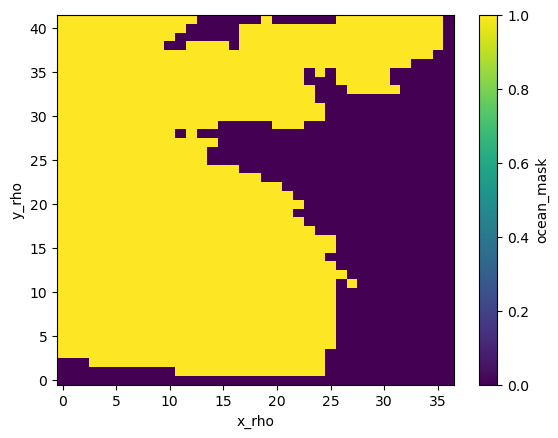

In [16]:
ds.ocean_mask.plot()

In [17]:
ds = ds.rename_vars({"nav_lat_rho": "latitude", "nav_lon_rho": "longitude"})

In [19]:
nside = 4096
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180

    return ds.assign_coords(longitude=centered)

In [20]:
%%time
# Define the target Healpix grid information
grid = HealpyGridInfo(level=int(np.log2(nside)))
target_grid = grid.target_grid(ds).pipe(center_longitude, 0)
target_grid

CPU times: user 906 ms, sys: 143 ms, total: 1.05 s
Wall time: 998 ms


<xarray.Dataset> Size: 51MB
Dimensions:     (cells: 2119755)
Coordinates:
    cell_ids    (cells) uint64 17MB 11151872 11151874 ... 83886078 83886079
    latitude    (cells) float64 17MB 40.05 40.06 40.07 ... 41.79 41.79 41.8
    longitude   (cells) float64 17MB 1.582 1.571 1.582 ... 0.01099 -0.01099 0.0
    resolution  float64 8B 0.0002498
Dimensions without coordinates: cells
Data variables:
    *empty*
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

In [7]:
#ds["nav_lat_rho"] = ds["nav_lat_rho"].assign_attrs(standard_nanme="latitude")
#ds["nav_lon_rho"] = ds["nav_lon_rho"].assign_attrs(standard_nanme="longitude")

In [21]:
ds[["longitude", "latitude"]].compute()

<xarray.Dataset> Size: 12kB
Dimensions:    (y_rho: 42, x_rho: 37)
Coordinates:
    longitude  (y_rho, x_rho) float32 6kB -1.0 -1.0 -1.0 ... 1.067 1.333 1.6
    latitude   (y_rho, x_rho) float32 6kB -1.0 -1.0 -1.0 ... 50.72 50.72 50.72
Dimensions without coordinates: y_rho, x_rho
Data variables:
    *empty*
Attributes: (12/45)
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...
    Conventions:    CF-1.6
    Cs_r:           have a look at variable Cs_r in this file
    Cs_w:           have a look at variable Cs_w in this file
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    Tcline:         15.0
    ...             ...
    title:          GAMAR_GLORYS
    tnu4_expl:      biharmonic mixing coefficient for tracers
    units:          meter4 second-1
    uuid:           06f6b784-fcc0-4422-aceb-17da2a5aa9fa
    v_sponge:       0.0
    x_sponge:       0.0

In [ ]:
%%time
# Compute the interpolation weights for regridding the diff data
regridder = HealpyRegridder(
    ds[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={"mask":"ocean_mask"},
)
regridder